# Exploring Adaptive sampling output reports

A monoploid plant with a genome size of ~600mb was used for this experiment. It has a relatively good assembly but a few gaps remain. 29 of these assembly gaps have been filled in using other methods and are used as a positive control here. 

We targeted these known gaps to see if the ONT adaptive sampling could fill in these gaps. 

We tried 3 different reference files that targeted the flanking regions of the known gaps. One reference file was used twice. The size of the flanks changed depending on the reference file:

| Run                                 | % of Genome Targeted |
|-------------------------------------|----------------------|
| Control (in-house)                  | 0%                   |
| AS2 Load1                           | 4%                   |
| AS2 Load2                           | 4%                   |
| AS8                                 | 10%                  |
| AS20                                | 21%                  |


The aim was to see what percentage of the genome should be targeted for gap-filling purposes. This will be a tradeoff between sequencing output and percentage of reads on-target.

Sequencing was done on a GridION at Auckland Genomics. All of the runs were done from one library prep made from needle (30G) sheared gDNA extractions. 
- protocol=sequencing_MIN114_DNA_e8_2_400T:FLO-MIN114:
- Lib_prep_Kits=SQK-LSK114

## Input data and clean


In [ ]:
library(dplyr)
library(ggplot2)
library(stringr)

In [2]:
#### Read data ####
## as2b is formatted differently. Not using for now.

# as20<-read.table(file = "$IN1/sequencing_summary_FAV46570_55fb1914.txt",
#                  header= TRUE)
# as8<-read.table(file = "$IN2/sequencing_summary_FAV46570_c67d43a7.txt",
#                  header= TRUE)
# as2a<-read.table(file = "$IN3/sequencing_summary_FAV46570_f4bca0b6.txt",
#                  header= TRUE)
# as2b<-read.table(file = "$IN4/sequencing_summary_FAV46570_f4bca0b6.txt",
#                  header= TRUE)




In [3]:
# Seting colour palette.
cbPalette <- c("#E69F00", "#56B4E9")
#scale_fill_manual(values=cbPalette)
#scale_colour_manual(values=cbPalette)


In [4]:
#combine all
as <- as20 %>% bind_rows(as8) %>% bind_rows(as2a) %>% bind_rows(as2b)
#check
length(row.names(as20))+length(row.names(as8))+length(row.names(as2a))+length(row.names(as2b)) == length(row.names(as))
colnames(as2a)==colnames(as)

[1] TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [5]:
# Replace Nanopores cryptic end_reason variables with human readable ones.
as <- as %>% mutate(end_reason = str_replace(end_reason, "data_service_unblock_mux_change", "Off-Target"))
as <- as %>% mutate(end_reason = str_replace(end_reason, "signal_positive", "On-Target"))

In [8]:
### Annonymize ###
as <- as %>%
  mutate(across('sample_id', str_replace, 'IN', ''))

In [20]:
# Clean up the data by removing very rare end-reasons.
as <- as %>% filter(end_reason=="On-Target" | end_reason=="Off-Target")

In [21]:
# Remove failed reads
as2 <- as2 %>% filter(passes_filtering=="TRUE")


In [16]:
colnames(as)
#Adaptive sampling treatment = sample_id
#End reason for read = end_reason
#Length of read = sequence_length_template
#Mean q score of read = mean_qscore_template

[1] "filename_fastq"           "filename_fast5"          
 [3] "parent_read_id"           "read_id"                 
 [5] "run_id"                   "channel"                 
 [7] "mux"                      "minknow_events"          
 [9] "start_time"               "duration"                
[11] "passes_filtering"         "template_start"          
[13] "num_events_template"      "template_duration"       
[15] "sequence_length_template" "mean_qscore_template"    
[17] "strand_score_template"    "median_template"         
[19] "mad_template"             "pore_type"               
[21] "experiment_id"            "sample_id"               
[23] "end_reason"

In [22]:
#Max Read for each AS treatment
as2 %>% group_by(sample_id) %>% summarise(max=max(sequence_length_template))

sample_id,max
<chr>,<int>
as02,82771
as02_load2,62199
as08,54288
as20,80061


In [24]:
#Number of Read for each AS treatment
#Passed Reads
as2 %>% group_by(sample_id,end_reason) %>% summarise(Count=n())
#Failed Reads
as %>% filter(passes_filtering=="FALSE") %>% group_by(sample_id,end_reason) %>% summarise(Count=n())


`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.


sample_id,end_reason,Count
<chr>,<chr>,<int>
as02,Off-Target,79014
as02,On-Target,73788
as02_load2,Off-Target,37211
as02_load2,On-Target,27514
as08,Off-Target,58195
as08,On-Target,66223
as20,Off-Target,65859
as20,On-Target,99345


`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.


sample_id,end_reason,Count
<chr>,<chr>,<int>
as02,Off-Target,41298
as02,On-Target,29109
as02_load2,Off-Target,32097
as02_load2,On-Target,17962
as08,Off-Target,33157
as08,On-Target,24968
as20,Off-Target,25699
as20,On-Target,18777


# Results:

#### Does the percentage of reads passing change with end_reason?

| Dataset       | ReadType   | NumReadsFail | NumReadsPass | Percent Fail |
|---------------|------------|--------------|--------------|--------------|
| as02 | Off-Target | 41298        | 79014        | 34%          |
| as02 | On-Target  | 29109        | 73788        | 28%          |
| as02_load2 | Off-Target | 32097        | 37211        | 46%          |
| as02_load2 | On-Target  | 17962        | 27514        | 39%          |
| as08 | Off-Target | 33157        | 58195        | 36%          |
| as08 | On-Target  | 24968        | 66223        | 27%          |
| as20 | Off-Target | 25699        | 65859        | 28%          |
| as20 | On-Target  | 18777        | 99345        | 16%          |

#### Is the proportion of reads on target affected by the size of the input file?

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"


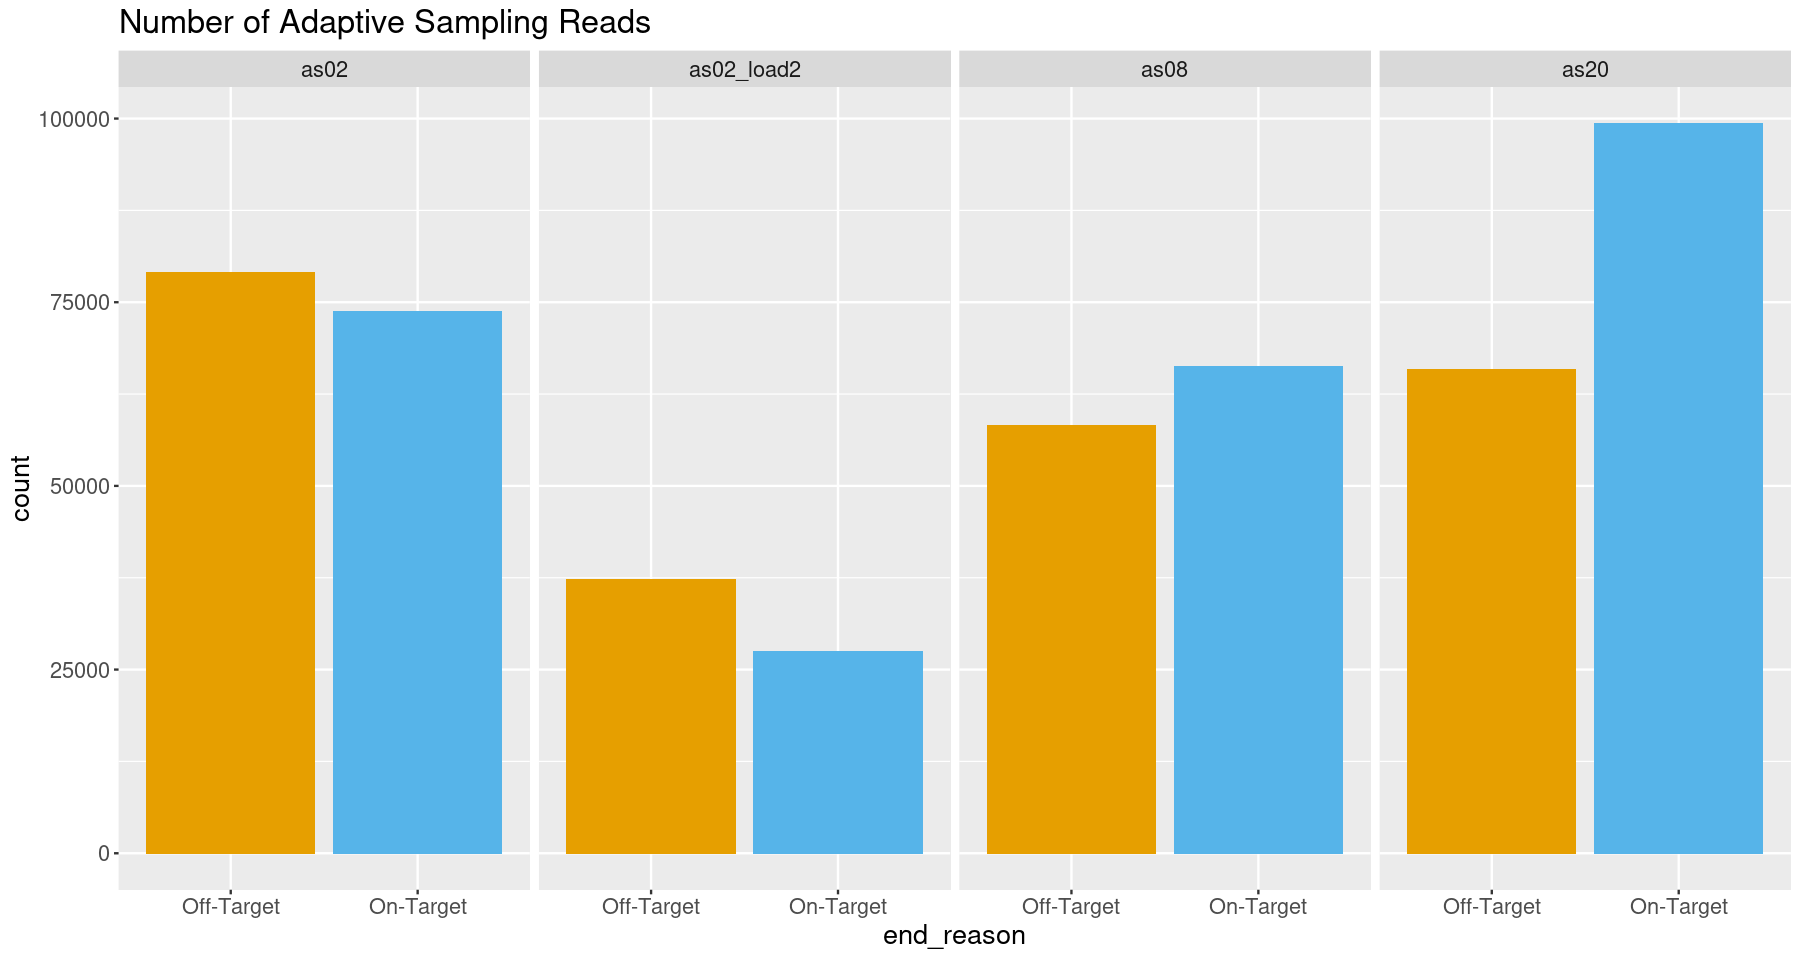

In [33]:
options(repr.plot.width=15, repr.plot.height=8)

# Readcount by reference treatment.
# 
viza <- as2 %>% ggplot(aes(x=end_reason, fill = end_reason)) + geom_histogram(stat = "count") + theme(legend.position = "none",text=element_text(size=16)) +scale_fill_manual(values=cbPalette)

vizb<- viza + facet_wrap( ~ sample_id, nrow = 1) + labs(title="Number of Adaptive Sampling Reads")
vizb

| Dataset       | Off-Target | On-Target | % on target |
|---------------|------------|-----------|-------------|
| as02 | 79,014     | 73,788    | 48%         |
| as02_load2 | 37,211     | 27,514    | 43%         |
| as08 | 58,195     | 66,223    | 53%         |
| as20 | 65,859     | 99,345    | 60%         |

#### How are read lengths affected by the size of the reference file?

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"
Warning message:
"Removed 92452 rows containing non-finite values (stat_count)."
Warning message:
"Removed 1 rows containing missing values (geom_bar)."
Warning message:
"Removed 423628 rows containing non-finite values (stat_count)."
Warning message:
"Removed 2 rows containing missing values (geom_bar)."


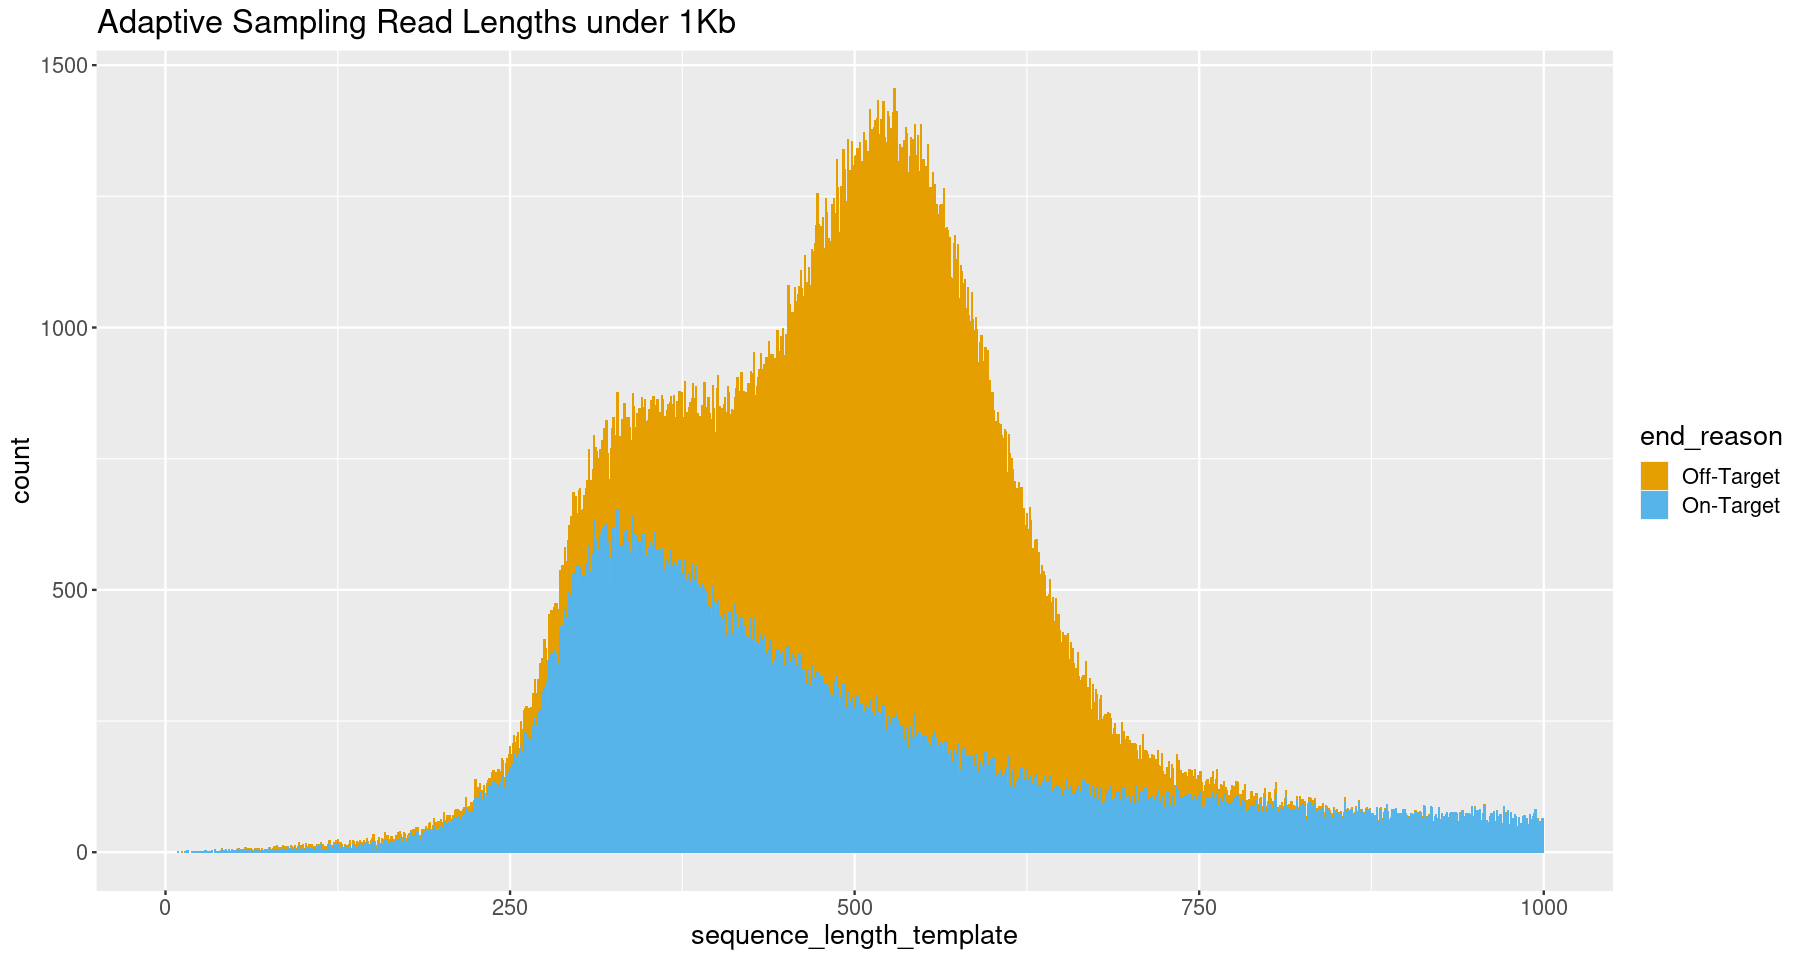

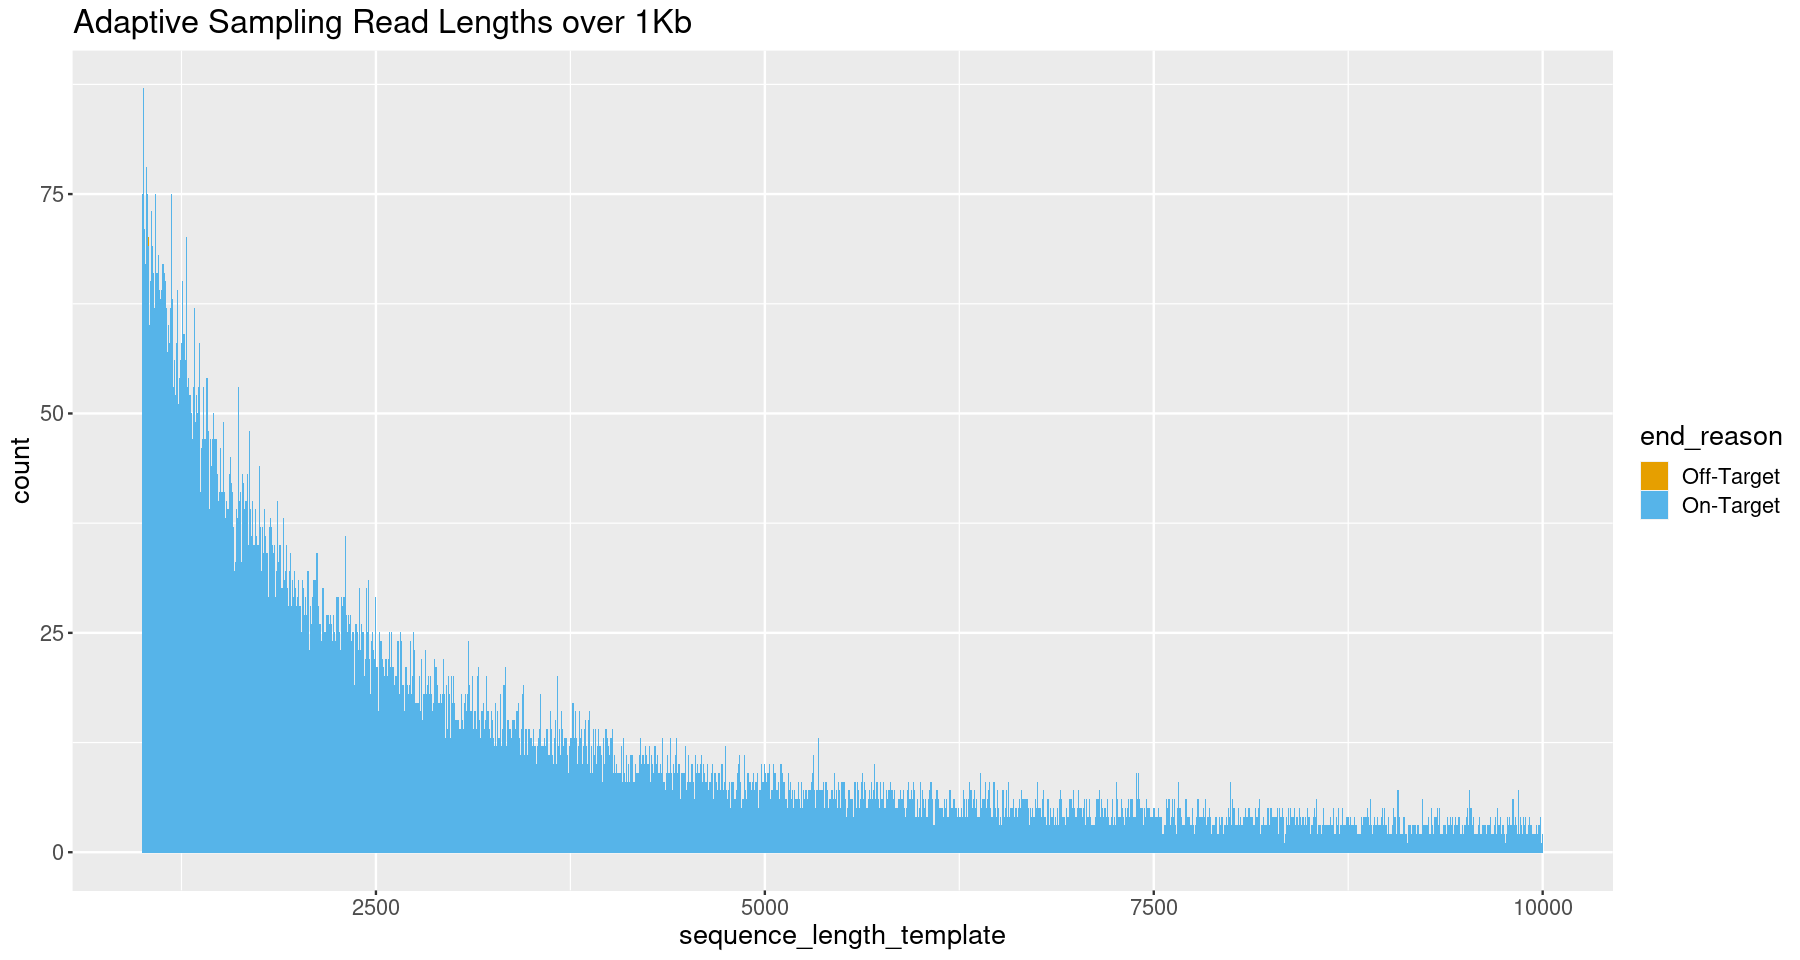

In [34]:
options(repr.plot.width=15, repr.plot.height=8)
#Read Lengths
viza2 <- as2  %>% ggplot(aes(x=sequence_length_template, fill = end_reason)) + geom_histogram(stat = "count") + scale_fill_manual(values=cbPalette) + theme(text=element_text(size=16))
viza2 + xlim(0,1000) + labs(title="Adaptive Sampling Read Lengths under 1Kb")
viza2 + xlim(1000,10000) + labs(title="Adaptive Sampling Read Lengths over 1Kb")

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
"Removed 92452 rows containing non-finite values (stat_count)."
Warning message:
"Removed 4 rows containing missing values (geom_bar)."
Warning message:
"Removed 423628 rows containing non-finite values (stat_count)."
Warning message:
"Removed 5 rows containing missing values (geom_bar)."


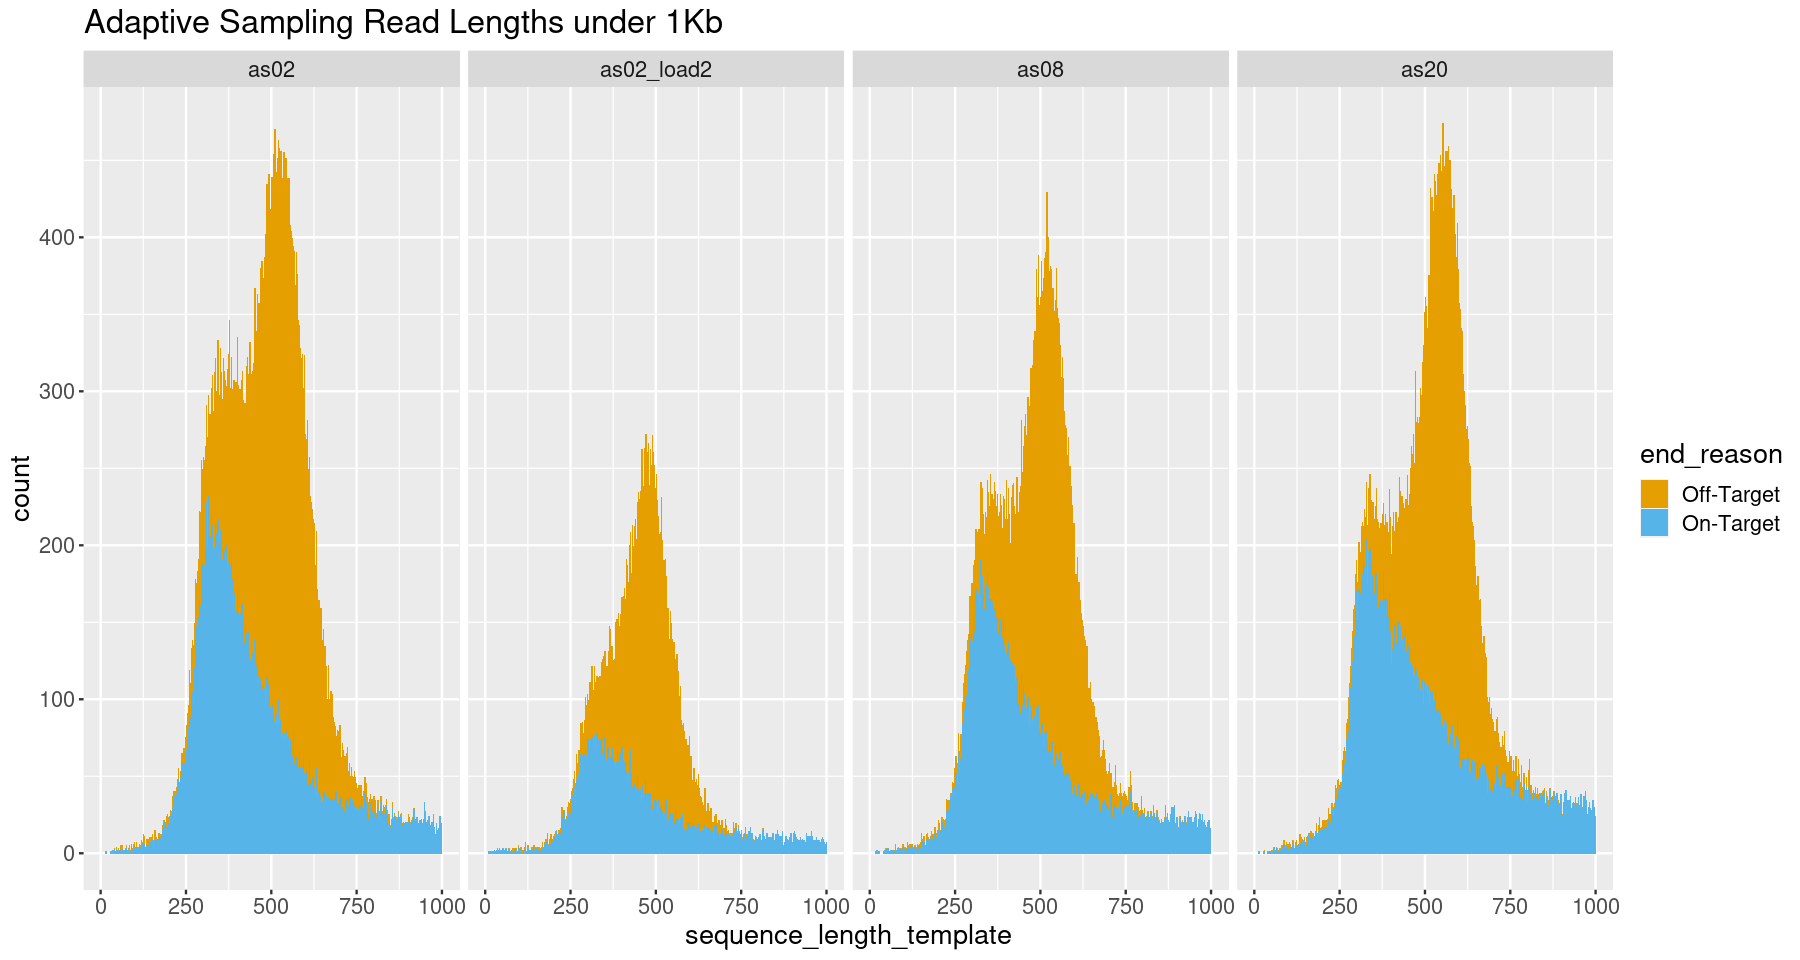

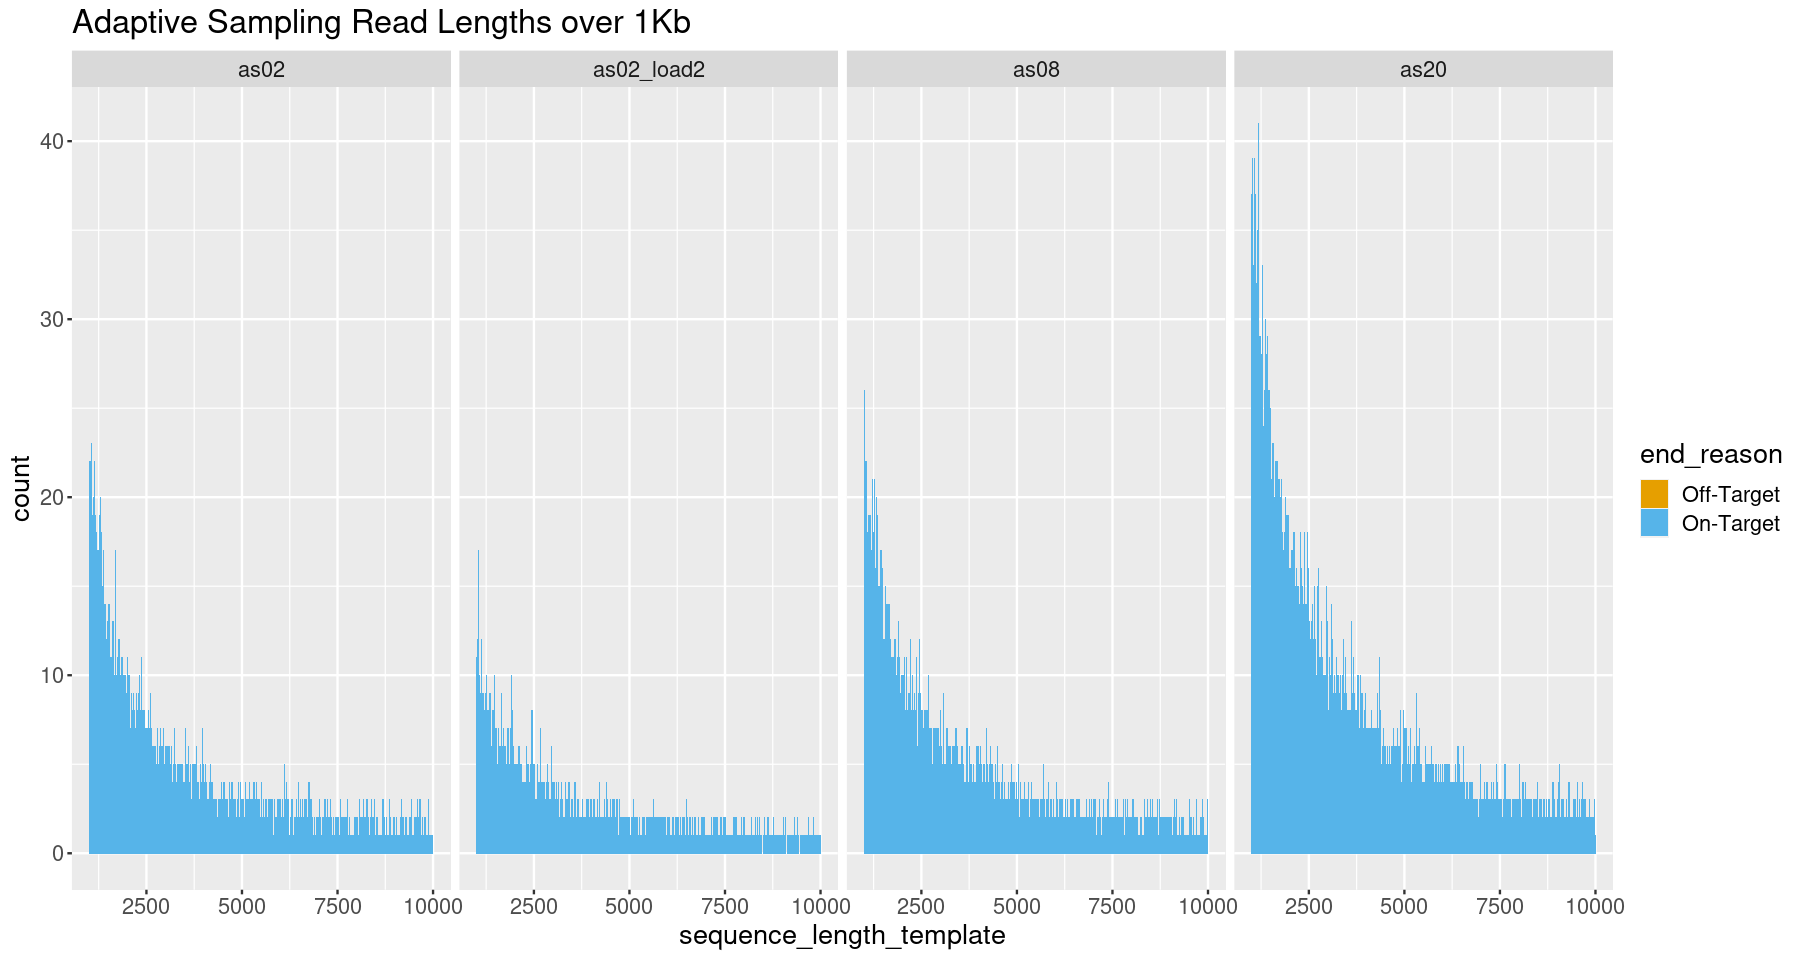

In [35]:
# Readlen by reference treatment.
options(repr.plot.width=15, repr.plot.height=8)
vizb2<- viza2 + facet_wrap( ~ sample_id, nrow = 1) + scale_fill_manual(values=cbPalette)+ theme(text=element_text(size=16))
vizb2 + xlim(0,1000) + labs(title="Adaptive Sampling Read Lengths under 1Kb")
vizb2 + xlim(1000,10000) + labs(title="Adaptive Sampling Read Lengths over 1Kb")

#### What was the yield on vs off-target?

In [28]:
#Total Yield of passed reads
as2 %>% group_by(sample_id) %>% summarise(YieldMb=(sum(sequence_length_template)/1000000))

sample_id,YieldMb
<chr>,<dbl>
as02,139.90057
as02_load2,64.78191
as08,142.28610
as20,259.64916


In [29]:
# Total Yield broken down
as2 %>% group_by(sample_id,end_reason) %>% summarise(YieldMb=(sum(sequence_length_template)/1000000))

`summarise()` has grouped output by 'sample_id'. You can override using the
`.groups` argument.


sample_id,end_reason,YieldMb
<chr>,<chr>,<dbl>
as02,Off-Target,40.10773
as02,On-Target,99.79284
as02_load2,Off-Target,17.48875
as02_load2,On-Target,47.29316
as08,Off-Target,29.65639
as08,On-Target,112.62971
as20,Off-Target,35.62428
as20,On-Target,224.02488


# Conclusion

| Run                     | Size of Target File (Mb) | % of Genome Targeted | Run Order | Time Run (hrs) | Yield    (Mb) | Yield/Hr | Yield On-Target | Normalized Yield    | Normalized Yield/Hr | % Reads on Target | Gaps Filled  | Fold Enrichment  |
|-------------------------|--------------------------|----------------------|-----------|----------------|---------------|----------|-----------------|---------------------|---------------------|-------------------|--------------|--------------|
|                         |                          |                      |           |                | (Q>8)         |          |                 | (Yield on-target/Mb Targeted) |                     |                   | (out of 29)  |  (%Genome Target x Yield/hr of Control) / (Yield/hr)   |
| Control (in-house)      |                          | 0%                   |           | 20             | 1240          | 62       |                 |                     |                     |                   |              |
| AS2 Load1               | 27                       | 4%                   | 1         | 15             | 140           | 9.5      | 100             | 3.70                | 0.25                | 48%               | 15           | 3.83 |
| AS2 Load2               | 27                       | 4%                   | 4         | 17             | 66.6          | 3.9      | 47.2            | 1.74                | 0.10                  | 43%               | ?            | 1.57 |
| AS8                     | 76                       | 10%                  | 2         | 17             | 142           | 8.6      | 112             | 1.47                | 0.09                | 53%               | 12           | 1.39 |
| AS20                    | 158                      | 21%                  | 3         | 5              | 260           | 53.3     | 224             | 1.42                | 0.28                | 60%               | 15           | 4.09 |
| Adaptive Sampling Total |                          |                      |           | 54             | 608.6         | 11.3     | 483             |                     |                     |                   | 18           |       |




+ The decision to keep reading or not occurs at around 500bp. All reads above 1kb are on-target.
+ Quality scores of the reads is not correlated to on or off-target.
+ The proportion of reads on-target increases as the size of the reference file increases, but not drastically so. 
+ Output decreases with smaller target files and it decreases over the course of the run.
+ The Yield/Hr is comparable between the Control (no adaptive sampling) and the AS20 run. 
+ The yield on-target normalized to the size of the reference file gives us an idea of how effectively the adaptive sampling is working. Despite the fact that the normalized yield is much higher in the AS2 dataset, if we take the hours run to get to that point the AS20 dataset worked better. Especially since it was loaded third onto the run when many of the pores were clogged.
+ It is interesting that the AS8 dataset did so poorly in the Normalized Yield/hr....
+ I expected the Normalized Yield to be correlated with the # number of control gaps filled but that does not appear to be the case.
